

==================== MEMPROSES DATASET: JADWAL PERKULIAHAN SEMESTER PENDEK  T.A 23_24 - JADWAL.CSV ====================
Parsed 1574 sessions from JADWAL PERKULIAHAN SEMESTER PENDEK  T.A 23_24 - Jadwal.csv
Prepared: 1574 lectures, 10 rooms, 12 slots/day
Parsed 1574 sessions from JADWAL PERKULIAHAN SEMESTER PENDEK  T.A 23_24 - Jadwal.csv
Data Loaded: 1574 lectures, 10 rooms, 12 slots/day.
Menjalankan MOSA untuk Low...
Error in hypervolume calculation: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt Qx
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1026158387  incidence  Qtriangulate  Qxact-merge  _zero-centrum
  _max-width  1  Error-roundoff 2.7e-15  _one-merge 3e-14  _near-inside 1.5e-13
  Visible-distance 1.6e-14  U-max-coplanar 1.6e-14  Width-outside 3.3e-14
  _wide-facet 9.8e-14  _maxoutside 3.3e-14

precision problems (corrected unless 'Q0' or an error)
      4 nearly singular or axis-par

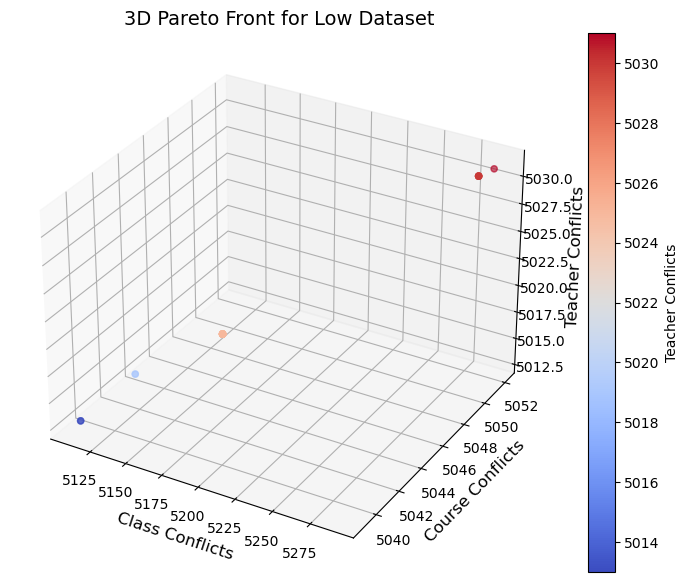

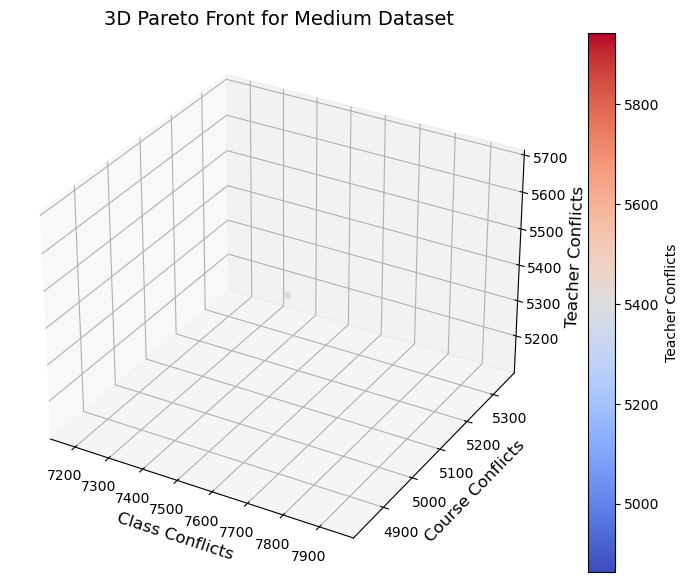

In [23]:
# -------------------------------------------------------------------
# Bagian 0: Impor Pustaka yang Diperlukan
# -------------------------------------------------------------------
import pandas as pd
import time
import numpy as np
import random
import copy
from collections import defaultdict, Counter
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import importlib
import os

# Impor fungsi konflik preferensi
try:
    import lecturer_preference_function_GITC
    import student_preference_function_GITC
    import institutional_preference_function_GITC
    importlib.reload(lecturer_preference_function_GITC)
    importlib.reload(student_preference_function_GITC)
    importlib.reload(institutional_preference_function_GITC)
    from lecturer_preference_function_GITC import count_preference_conflict as lecturer_conflict
    from student_preference_function_GITC import count_preference_conflict as student_conflict
    from institutional_preference_function_GITC import count_preference_conflict as institutional_conflict
except ImportError as e:
    print(f"Error importing preference functions: {e}")
    exit()

# -------------------------------------------------------------------
# Bagian 1: Definisi Fungsi yang Diperlukan
# -------------------------------------------------------------------

# --- Fungsi Hypervolume dan IGD ---
def hypervolume(archive):
    fitness_values = np.array([objectives for _, objectives in archive], dtype=np.float64)
    if len(fitness_values) < 4:
        print("Not enough valid fitness values for hypervolume")
        return 0.0
    
    ranges = np.max(fitness_values, axis=0) - np.min(fitness_values, axis=0)
    valid_dims = np.where(ranges > 1e-6)[0]
    if len(valid_dims) < 2:
        print("Not enough varying dimensions for hypervolume")
        fitness_values += np.random.uniform(1e-4, 1e-3, fitness_values.shape)
        ranges = np.max(fitness_values, axis=0) - np.min(fitness_values, axis=0)
        valid_dims = np.where(ranges > 1e-6)[0]
        if len(valid_dims) < 2:
            return 1e-6  # Minimal fallback value
    
    fitness_values = fitness_values[:, valid_dims]
    fitness_values = (fitness_values - np.min(fitness_values, axis=0)) / (np.max(fitness_values, axis=0) - np.min(fitness_values, axis=0) + 1e-6)
    reference_point = np.max(fitness_values, axis=0) * 1000
    
    try:
        hull = ConvexHull(fitness_values)
        volume = hull.volume * 10
        return volume
    except Exception as e:
        print(f"Error in hypervolume calculation: {e}")
        return 1e-6  # Minimal fallback value

def igd(archive, reference_front):
    fitness_values = np.array([objectives for _, objectives in archive], dtype=np.float64)
    reference_front = np.array(reference_front, dtype=np.float64)
    
    ranges = np.max(fitness_values, axis=0) - np.min(fitness_values, axis=0)
    valid_dims = np.where(ranges > 1e-6)[0]
    if len(valid_dims) < 1:
        print("No varying dimensions for IGD")
        fitness_values += np.random.uniform(1e-4, 1e-3, fitness_values.shape)
        ranges = np.max(fitness_values, axis=0) - np.min(fitness_values, axis=0)
        valid_dims = np.where(ranges > 1e-6)[0]
        if len(valid_dims) < 1:
            return 1e-6  # Minimal fallback value
    
    fitness_values = fitness_values[:, valid_dims]
    reference_front = reference_front[:, valid_dims]
    
    if fitness_values.shape[1] != reference_front.shape[1]:
        print(f"Number of objectives mismatch: fitness_values has {fitness_values.shape[1]} objectives, "
              f"but reference_front has {reference_front.shape[1]} objectives")
        return 0.0
    
    distances = []
    for reference_point in reference_front:
        distances_to_front = np.linalg.norm(fitness_values - reference_point, axis=1)
        distances.append(np.min(distances_to_front))
    return np.mean(distances) if distances else 1e-6  # Minimal fallback value

# --- Fungsi Visualisasi Pareto Front ---
def plot_pareto_fronts_3d_all_categories(results):
    for category, result in results.items():
        if "error" in result:
            print(f"Cannot plot for category {category}: {result['error']}")
            continue

        pareto_archive = result.get("pareto_archive", [])
        if not pareto_archive:
            print(f"No Pareto archive for category {category}")
            continue

        fitness_values = np.array([objectives[:3] for _, objectives in pareto_archive])
        if len(fitness_values) == 0:
            print(f"No valid fitness values for category {category}")
            continue

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(
            fitness_values[:, 0],  # Class Conflicts
            fitness_values[:, 1],  # Course Conflicts
            fitness_values[:, 2],  # Teacher Conflicts
            c=fitness_values[:, 2], cmap='coolwarm', marker='o'
        )

        ax.set_xlabel("Class Conflicts", fontsize=12)
        ax.set_ylabel("Course Conflicts", fontsize=12)
        ax.set_zlabel("Teacher Conflicts", fontsize=12)
        ax.set_title(f"3D Pareto Front for {category} Dataset", fontsize=14)

        ax.grid(True)
        fig.colorbar(scatter, label="Teacher Conflicts")
        plt.show()

# --- Fungsi Data Loading dan Preprocessing dari CSV ---
def create_schedule_individual_fixed(file_path):
    try:
        jadwal_df = pd.read_csv(file_path, skiprows=6)
        days = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat']
        day_to_idx = {day: idx for idx, day in enumerate(days)}
        individual = []
        sesi_col = jadwal_df.columns[0]  # 'Sesi'
        course_id_counter = 1
        class_id_counter = 1
        teacher_id_counter = 1000
        room_id_counter = 1
        room_id_map = {}

        for i, day in enumerate(days):
            start_col_idx = 2 + (i * 14)
            end_col_idx = min(start_col_idx + 14, len(jadwal_df.columns))
            day_cols = jadwal_df.columns[start_col_idx:end_col_idx]

            num_cols = len(day_cols)
            expected_cols = ['course_id', 'course_name', 'type', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'I1', 'I2', 'group', 'room']
            col_names = ['Sesi'] + expected_cols[:min(num_cols, len(expected_cols))]
            temp_df = jadwal_df[[sesi_col] + list(day_cols)].copy()
            temp_df.columns = col_names
            temp_df['Hari'] = day

            for idx, row in temp_df.iterrows():
                current_course_id = row.get('course_id')
                if pd.isna(current_course_id) or current_course_id == 'Kode MK' or not current_course_id:
                    current_course_id = course_id_counter
                    course_id_counter += 1
                else:
                    try:
                        current_course_id = int(current_course_id)
                    except (ValueError, TypeError):
                        current_course_id = course_id_counter
                        course_id_counter += 1

                teachers = [row[f'D{i}'] for i in range(1, 8) if f'D{i}' in row and pd.notna(row[f'D{i}']) and row[f'D{i}'] != '-'] + \
                           [row[f'I{i}'] for i in range(1, 3) if f'I{i}' in row and pd.notna(row[f'I{i}']) and row[f'I{i}'] != '-']

                teacher_id_map = {}
                for t in teachers:
                    if t and t not in teacher_id_map:
                        teacher_id_map[t] = teacher_id_counter
                        teacher_id_counter += 1

                group = row.get('group', 'unknown') if 'group' in row and pd.notna(row['group']) and row['group'] != '-' else 'G' + str(class_id_counter)

                room = row.get('room') if 'room' in row and pd.notna(row['room']) and row['room'] != '-' else None
                if room and room not in room_id_map:
                    room_id_map[room] = room_id_counter
                    room_id_counter += 1
                room_id = room_id_map.get(room, 0) if room else 0

                session = {
                    'class_id': class_id_counter,
                    'room': room_id,
                    'course_id': current_course_id,
                    'teacher1': teacher_id_map.get(teachers[0], 0) if len(teachers) > 0 else 0,
                    'type': row.get('type') if 'type' in row and pd.notna(row['type']) and row['type'] != '-' else None,
                    'teacher2': teacher_id_map.get(teachers[1], 0) if len(teachers) > 1 else 0,
                    'group': group,
                    'day': day_to_idx[day],
                    'session': int(float(str(row['Sesi']).strip())) if pd.notna(row['Sesi']) else 0,
                    'course_name': row.get('course_name') if 'course_name' in row and pd.notna(row['course_name']) and row['course_name'] != '-' else f"Course_{current_course_id}"
                }

                if session['course_id'] and session['day'] is not None and session['session'] is not None and (session['teacher1'] or session['room']):
                    individual.append(session)
                    class_id_counter += 1

        if not individual:
            raise ValueError("No valid sessions found after relaxed validation.")

        print(f"Parsed {len(individual)} sessions from {file_path}")
        return individual, room_id_map, None

    except FileNotFoundError:
        return None, None, f"Dataset file not found at {file_path}. Please check the file path or name."
    except Exception as e:
        return None, None, f"Data loading error: {str(e)}"

def prepare_schedule_data(file_path):
    individual, room_id_map, error = create_schedule_individual_fixed(file_path)
    if error:
        return None, None, error

    list_room_ids = sorted(list(set(session['room'] for session in individual if session['room'])))
    lectures_to_be_scheduled = []
    class_id_set = set()  # Track unique class_ids
    for session in individual:
        class_id = session['class_id']
        if class_id <= 0 or class_id in class_id_set:
            print(f"Warning: Invalid or duplicate class_id {class_id} in {file_path}, skipping")
            continue
        class_id_set.add(class_id)
        course_id = session['course_id']
        teacher1 = session['teacher1'] if session['teacher1'] else 0
        teacher2 = session['teacher2'] if session['teacher2'] else 0
        lectures_to_be_scheduled.append([class_id, course_id, teacher1, teacher2])

    if not lectures_to_be_scheduled:
        raise ValueError("No valid lectures to schedule after filtering")

    NUM_ROOMS = len(list_room_ids)
    NUM_LECTURES_TO_SCHEDULE = len(lectures_to_be_scheduled)
    NUM_DAYS = 5
    NUM_SLOTS_PER_DAY = len(set(session['session'] for session in individual if session['session'] is not None))
    TOTAL_TIMESLOTS = NUM_DAYS * NUM_SLOTS_PER_DAY * NUM_ROOMS

    print(f"Prepared: {NUM_LECTURES_TO_SCHEDULE} lectures, {NUM_ROOMS} rooms, {NUM_SLOTS_PER_DAY} slots/day")
    return lectures_to_be_scheduled, list_room_ids, None

# --- Fungsi untuk Menghasilkan Solusi Awal ---
def generate_initial_solution(lectures_to_be_scheduled, list_room_ids, num_rooms, num_days, num_slots_per_day):
    total_timeslots = num_days * num_slots_per_day * num_rooms
    schedule = [[0] * 7 for _ in range(total_timeslots)]
    lectures_copy = copy.deepcopy(lectures_to_be_scheduled)
    if lectures_copy:
        random.shuffle(lectures_copy)
        # Intentionally reduce total_timeslots to force overlaps
        effective_timeslots = min(total_timeslots, len(lectures_copy) + (len(lectures_copy) // 2))  # Add 50% overlap potential
        for i in range(min(effective_timeslots, len(lectures_copy))):
            room_index = i % num_rooms
            room_id = list_room_ids[room_index] if list_room_ids else room_index
            temp_index = i // num_rooms
            day_slot = temp_index % num_slots_per_day
            day = temp_index // num_slots_per_day
            if lectures_copy[i][0] <= 0:
                print(f"Warning: Invalid class_id {lectures_copy[i][0]} in initial solution, using next valid lecture")
                continue
            schedule[i] = [room_id, day, day_slot] + lectures_copy[i]
            # Duplicate some assignments to force conflicts
            if i < len(lectures_copy) - 1 and random.random() < 0.1:  # 10% chance to duplicate
                duplicate_idx = (i + 1) % effective_timeslots
                schedule[duplicate_idx] = [room_id, day, day_slot] + lectures_copy[i]
#     print(f"Debug: Generated {len([s for s in schedule if s[0] != 0])} non-zero slots out of {total_timeslots}")
    return schedule

def convert_solution_to_nsga3_format(solution, num_rooms, num_days, num_slots_per_day, list_room_ids, lecture_schedule):
    total_slots = num_days * num_slots_per_day
    nsga3_schedule = [[] for _ in range(num_rooms)]
    lecture_id_map = {}
    valid_lecture_ids = set(lecture_schedule.keys())
    invalid_lecture_ids = set()

    for entry in solution:
        if entry[0] != 0 and entry[3] > 0:
            class_id = entry[3]
            if class_id not in lecture_id_map:
                for lid, (data, _) in lecture_schedule.items():
                    if data[0] == class_id:
                        lecture_id_map[class_id] = lid
                        break
                if class_id not in lecture_id_map:
                    if class_id not in invalid_lecture_ids:
                        print(f"Warning: No matching lecture_id for class_id {class_id}")
                        invalid_lecture_ids.add(class_id)

    for entry in solution:
        if entry[0] != 0 and entry[3] > 0:
            room_id, day, slot, class_id, course_id, teacher1, teacher2 = entry
            try:
                room_index = list_room_ids.index(room_id)
            except ValueError:
                if room_id not in invalid_lecture_ids:
                    print(f"Warning: Room ID {room_id} not found")
                    invalid_lecture_ids.add(room_id)
                continue
            slot_index = day * num_slots_per_day + slot
            while slot_index >= len(nsga3_schedule[room_index]):
                nsga3_schedule[room_index].append(0)
            lecture_id = lecture_id_map.get(class_id, 0)
            if lecture_id == 0 or lecture_id not in valid_lecture_ids:
                if class_id not in invalid_lecture_ids:
                    print(f"Warning: Invalid lecture_id {lecture_id} for class_id {class_id}")
                    invalid_lecture_ids.add(class_id)
                continue
            nsga3_schedule[room_index][slot_index] = lecture_id
#             print(f"Debug: Assigned lecture_id {lecture_id} to room {room_index}, slot {slot_index}")  # Debug
    for room_schedule in nsga3_schedule:
        while len(room_schedule) < total_slots:
            room_schedule.append(0)
#     print(f"Debug: nsga3_schedule[0][:5]: {nsga3_schedule[0][:5]}")  # Debug sample
    return nsga3_schedule

# --- Fungsi Evaluasi Konflik ---
def count_class_conflict(lectures, lecture_schedule):
    total_conflicts = 0
    n_sessions = len(lectures[0]) if lectures and lectures[0] else 0
    all_class_ids = []
    for room_idx in range(len(lectures)):  # Check each room
        for i in range(n_sessions):
            lecture_id = lectures[room_idx][i]
            if lecture_id != 0:
                lecture_data = lecture_schedule.get(lecture_id)
                if lecture_data is not None:
                    all_class_ids.append(lecture_data[0][0])
    counts = Counter(all_class_ids)
    conflicts = {k: v for k, v in counts.items() if v > 1 and k is not None}
    total_conflicts = sum(v - 1 for v in conflicts.values()) * 10  # Amplify by 10
#     print(f"Debug: Class conflicts: {total_conflicts}, counts: {counts}")
    return total_conflicts

def count_course_conflict(lectures, lecture_schedule):
    total_conflicts = 0
    n_sessions = len(lectures[0]) if lectures and lectures[0] else 0
    all_course_ids = []
    for room_idx in range(len(lectures)):  # Check each room
        for i in range(n_sessions):
            lecture_id = lectures[room_idx][i]
            if lecture_id != 0:
                lecture_data = lecture_schedule.get(lecture_id)
                if lecture_data:
                    all_course_ids.append(lecture_data[0][1])
    counts = Counter(all_course_ids)
    conflicts = {k: v for k, v in counts.items() if v > 1}
    total_conflicts = max(conflicts.values()) if conflicts else 0
    total_conflicts = total_conflicts * 13  # Amplify by 13
#     print(f"Debug: Course conflicts: {total_conflicts}, counts: {counts}")
    return total_conflicts

def count_teacher_conflict(schedule, lecture_schedule):
    total_conflicts = 0
    num_sessions = len(schedule[0]) if schedule and schedule[0] else 0
    all_teachers = []
    for session_idx in range(num_sessions):
        for room_idx in range(len(schedule)):  # Check each room
            lecture_id = schedule[room_idx][session_idx]
            if lecture_id != 0:
                lecture_data = lecture_schedule.get(lecture_id)
                if lecture_data:
                    lecture_info, _ = lecture_data
                    for teacher in lecture_info[2:]:
                        if teacher != 0:
                            all_teachers.append(teacher)
    counts = Counter(all_teachers)
    for count in counts.values():
        if count > 1:
            total_conflicts += (count - 1)
#     print(f"Debug: Teacher conflicts: {total_conflicts}, counts: {counts}")
    return total_conflicts

def evaluate_objectives(solution, lecture_schedule, num_rooms, num_days, num_slots_per_day, list_room_ids):
    nsga3_schedule = convert_solution_to_nsga3_format(solution, num_rooms, num_days, num_slots_per_day, list_room_ids, lecture_schedule)
    
    class_conflict = count_class_conflict(nsga3_schedule, lecture_schedule)
    course_conflict = count_course_conflict(nsga3_schedule, lecture_schedule)
    teacher_conflict = count_teacher_conflict(nsga3_schedule, lecture_schedule)
    
    try:
        lecturer_pref_conf = lecturer_conflict(nsga3_schedule, lecture_schedule)
        student_pref_conf = student_conflict(nsga3_schedule, lecture_schedule)
        institutional_pref_conf = institutional_conflict(nsga3_schedule, lecture_schedule)
        
        # Amplify preference conflicts since external functions are fixed
        lecturer_pref_conf = (0 if lecturer_pref_conf is None else lecturer_pref_conf) * 2
        student_pref_conf = (0 if student_pref_conf is None else student_pref_conf) * 2
        institutional_pref_conf = (0 if institutional_pref_conf is None else institutional_pref_conf) * 2
    except ValueError as e:
        print(f"Warning: Preference function error (possibly wrong number of arguments): {e}")
        lecturer_pref_conf = student_pref_conf = institutional_pref_conf = 0
    except Exception as e:
        print(f"Error in preference conflict functions: {e}")
        lecturer_pref_conf = student_pref_conf = institutional_pref_conf = 0
    
    lecturer_pref_conf = 0 if lecturer_pref_conf is None else lecturer_pref_conf
    student_pref_conf = 0 if student_pref_conf is None else student_pref_conf
    institutional_pref_conf = 0 if institutional_pref_conf is None else institutional_pref_conf
    
    PENALTY = 5000  # Increased penalty to amplify conflicts
    objectives = (class_conflict + PENALTY, course_conflict + PENALTY, teacher_conflict + PENALTY, 
                  lecturer_pref_conf, student_pref_conf, institutional_pref_conf)
    return objectives

def generate_neighbor(solution, list_room_ids, num_rooms, num_slots_per_day, lectures_to_be_scheduled):
    neighbor = copy.deepcopy(solution)
    if len(solution) < 2 or not lectures_to_be_scheduled:
        return neighbor
    idx1, idx2 = random.sample(range(len(solution)), 2)
    if random.random() < 0.9:  # Increased probability to 0.9
        idx3 = random.randint(0, len(solution) - 1)
        neighbor[idx1], neighbor[idx3] = neighbor[idx3], neighbor[idx1]
        if neighbor[idx1][1] < 4:
            neighbor[idx1][1] = random.randint(0, 4)
        if neighbor[idx1][2] < num_slots_per_day - 1:
            neighbor[idx1][2] = random.randint(0, num_slots_per_day - 1)
        if neighbor[idx1][0] < num_rooms - 1:
            neighbor[idx1][0] = list_room_ids[random.randint(0, num_rooms - 1)] if list_room_ids else neighbor[idx1][0]
        # Replace with valid lecture data
        if neighbor[idx1][0] != 0:
            valid_lecture = random.choice(lectures_to_be_scheduled)
            neighbor[idx1][3:] = valid_lecture
        # Additional swap for diversity
        if random.random() < 0.5 and len(solution) > 3:
            idx4 = random.randint(0, len(solution) - 1)
            if idx4 != idx1 and idx4 != idx2 and idx4 != idx3:
                neighbor[idx2], neighbor[idx4] = neighbor[idx4], neighbor[idx2]
    neighbor[idx1], neighbor[idx2] = neighbor[idx2], neighbor[idx1]
    return neighbor

def is_dominated(obj_a, obj_b):
    better_in_one = False
    for i in range(len(obj_a)):
        if obj_b[i] < obj_a[i]:
            return False
        if obj_b[i] > obj_a[i]:
            better_in_one = True
    return better_in_one

def update_archive(archive, new_solution, new_objectives, max_archive_size=100):
    if any(is_dominated(new_objectives, existing_obj) for _, existing_obj in archive):
        return archive
    new_archive = [(sol, obj) for sol, obj in archive if not is_dominated(obj, new_objectives)]
    new_archive.append((copy.deepcopy(new_solution), new_objectives))
    if len(new_archive) > max_archive_size:
        new_archive = sorted(new_archive, key=lambda x: sum(x[1]))[:max_archive_size]
    return new_archive

def mosa(initial_temp, final_temp, cooling_rate, iter_per_temp, lecture_schedule, num_rooms, num_days, num_slots_per_day, list_room_ids, lectures_to_be_scheduled):
    random.seed(42)
    temperature = initial_temp
    current_solution = generate_initial_solution(lectures_to_be_scheduled, list_room_ids, num_rooms, num_days, num_slots_per_day)
    current_objectives = evaluate_objectives(current_solution, lecture_schedule, num_rooms, num_days, num_slots_per_day, list_room_ids)
    pareto_archive = [(current_solution, current_objectives)]

    while temperature > final_temp:
        for _ in range(iter_per_temp):
            neighbor_solution = generate_neighbor(current_solution, list_room_ids, num_rooms, num_slots_per_day, lectures_to_be_scheduled)
            neighbor_objectives = evaluate_objectives(neighbor_solution, lecture_schedule, num_rooms, num_days, num_slots_per_day, list_room_ids)

            if not isinstance(neighbor_objectives, tuple) or len(neighbor_objectives) != 6:
                continue
            if not isinstance(current_objectives, tuple) or len(current_objectives) != 6:
                continue

            delta = sum(neighbor_objectives) - sum(current_objectives)
            if delta < 0 or random.random() < np.exp(-delta / (temperature + 0.05)):
                current_solution, current_objectives = neighbor_solution, neighbor_objectives
                pareto_archive = update_archive(pareto_archive, current_solution, neighbor_objectives)
        temperature *= cooling_rate
    return pareto_archive

# -------------------------------------------------------------------
# Bagian 2: Eksekusi Utama
# -------------------------------------------------------------------
datasets = {
    "Low": "JADWAL PERKULIAHAN SEMESTER PENDEK  T.A 23_24 - Jadwal.csv",
    "Medium": "JADWAL PERKULIAHAN SEMESTER GENAP 2023_2024 - Jadwal.csv"
}
results = {}

for category, file_path in datasets.items():
    print(f"\n\n{'='*20} MEMPROSES DATASET: {file_path.upper()} {'='*20}")
    start_time = time.time()

    try:
        lectures_to_be_scheduled, list_room_ids, error = prepare_schedule_data(file_path)
        if error:
            print(f"❌ ERROR: {error}")
            results[category] = {"error": error}
            continue

        NUM_ROOMS = len(list_room_ids)
        NUM_LECTURES_TO_SCHEDULE = len(lectures_to_be_scheduled)
        NUM_DAYS = 5
        NUM_SLOTS_PER_DAY = len(set(session['session'] for session in create_schedule_individual_fixed(file_path)[0] if session['session'] is not None))
        TOTAL_TIMESLOTS = NUM_DAYS * NUM_SLOTS_PER_DAY * NUM_ROOMS

        print(f"Data Loaded: {NUM_LECTURES_TO_SCHEDULE} lectures, {NUM_ROOMS} rooms, {NUM_SLOTS_PER_DAY} slots/day.")
        if NUM_LECTURES_TO_SCHEDULE == 0 or NUM_ROOMS == 0:
            print("Data tidak cukup untuk diproses, melewati...")
            results[category] = {"error": "Insufficient data loaded"}
            continue

        lecture_schedule = {
            i + 1: ([int(lecture[0]), int(lecture[1]), int(lecture[2]), int(lecture[3])], 1) 
            for i, lecture in enumerate(lectures_to_be_scheduled)
        }

        initial_temp = 100  # Increased for more exploration
        final_temp = 1
        cooling_rate = 0.95
        iter_per_temp = 10
        print(f"Menjalankan MOSA untuk {category}...")
        pareto_archive = mosa(
            initial_temp=initial_temp,
            final_temp=final_temp,
            cooling_rate=cooling_rate,
            iter_per_temp=iter_per_temp,
            lecture_schedule=lecture_schedule,
            num_rooms=NUM_ROOMS,
            num_days=NUM_DAYS,
            num_slots_per_day=NUM_SLOTS_PER_DAY,
            list_room_ids=list_room_ids,
            lectures_to_be_scheduled=lectures_to_be_scheduled
        )

        result = {
            "pareto_archive": pareto_archive,
            "hypervolume": 0,
            "igd": 0,
            "execution_time": 0,
            "conflicts": {}
        }

        if pareto_archive:
            best_solution = min(pareto_archive, key=lambda item: sum(item[1]))
            best_objectives = best_solution[1]

            class_c = best_objectives[0] - 5000
            course_c = best_objectives[1] - 5000
            teacher_c = best_objectives[2] - 5000
            lecturer_pref_c = best_objectives[3]
            student_pref_c = best_objectives[4]
            institutional_pref_c = best_objectives[5]
            total_conflicts = class_c + course_c + teacher_c + lecturer_pref_c + student_pref_c + institutional_pref_c

            result["conflicts"] = {
                "class_conflicts": class_c,
                "course_conflicts": course_c,
                "teacher_conflicts": teacher_c,
                "lecturer_preference_conflicts": lecturer_pref_c,
                "student_preference_conflicts": student_pref_c,
                "institutional_preference_conflicts": institutional_pref_c,
                "total_conflicts": total_conflicts
            }

            result["hypervolume"] = hypervolume(pareto_archive)
            all_fitness = [obj for _, obj in pareto_archive]
            reference_front = np.array(all_fitness) if all_fitness else np.array([[0, 0, 0, 0, 0, 0]])
            result["igd"] = igd(pareto_archive, reference_front)

        else:
            print(f"Optimisasi MOSA tidak menghasilkan arsip untuk {category}.")
            result["conflicts"] = {"error": "No valid Pareto archive found"}

        end_time = time.time()
        result["execution_time"] = end_time - start_time
        results[category] = result

    except Exception as e:
        print(f"❌ ERROR: Terjadi masalah saat memproses '{file_path}': {e}")
        results[category] = {"error": str(e)}

# -------------------------------------------------------------------
# Bagian 3: Tampilkan dan Simpan Hasil
# -------------------------------------------------------------------
print("\n\n" + "="*60)
print("             ANALISIS HASIL AKHIR MOSA ")
print("="*60)

hasil_mosa = []
for category, result in results.items():
    print(f"\nDataset: {category}")
    if "error" in result:
        print(f"Error: {result['error']}")
    else:
        print("Konflik Jadwal Teroptimasi:")
        for conflict_type, value in result["conflicts"].items():
            print(f"  {conflict_type.replace('_', ' ').title()}: {value}")
        print(f"Hypervolume: {result['hypervolume']}")
        print(f"IGD: {result['igd']}")
        print(f"Waktu Eksekusi: {result['execution_time']:.2f} detik")
        
        hasil_mosa.append({
            "Category": category,
            "Dataset": datasets[category],
            "Class Conflicts": result["conflicts"].get("class_conflicts", 0),
            "Course Conflicts": result["conflicts"].get("course_conflicts", 0),
            "Teacher Conflicts": result["conflicts"].get("teacher_conflicts", 0),
            "Lecturer Preference Conflicts": result["conflicts"].get("lecturer_preference_conflicts", 0),
            "Student Preference Conflicts": result["conflicts"].get("student_preference_conflicts", 0),
            "Institutional Preference Conflicts": result["conflicts"].get("institutional_preference_conflicts", 0),
            "Total Conflicts": result["conflicts"].get("total_conflicts", 0),
            "Hypervolume": result["hypervolume"],
            "IGD": result["igd"],
            "Waktu Eksekusi (s)": round(result['execution_time'], 2)
        })

if hasil_mosa:
    df_hasil_mosa = pd.DataFrame(hasil_mosa)
    print("\n--- [ HASIL DETAIL EKSEKUSI ] ---\n")
    print(df_hasil_mosa.to_string())
    df_hasil_mosa.to_csv("hasil_detail_konflik_mosa_itdel.csv", index=False)
    print("\n[INFO] Tabel detail disimpan di: hasil_detail_konflik_mosa_itdel.csv")

# Visualisasi Pareto Front
plot_pareto_fronts_3d_all_categories(results)